# Merge Sustainalytics-BS and Tayla's Pollution Data

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# set the max columns to none
pd.set_option('display.max_columns', None)

def jitter(values,j):
    return values + np.random.normal(0,j,values.shape)

import stata_setup
stata_setup.config("C:/Program Files/Stata17/", "be")

## Import and Prepare Data

#### Mina's Sustainalytics-BS Merged Data

In [22]:
sa_bs_columns = ["LPERMNO", "total_esg_score", "environment_score", "evtdate", "sell", "amountE", "icpsr_id"]

In [23]:
sa_bs = pd.read_csv("../data/minas_esg/sustainalytics_bs_merge.csv", encoding="latin-1")[sa_bs_columns]\
        .dropna(subset=["icpsr_id", "amountE"])
sa_bs

,LPERMNO,total_esg_score,environment_score,evtdate,sell,amountE,icpsr_id
2,21020,55.29,44.32,2019-06-24,1.0,1000.0,20748.0
6,21020,55.24,44.19,2020-06-11,0.0,1000.0,21128.0
7,21020,55.24,44.19,2020-07-02,1.0,8000.5,14852.0
10,21020,55.24,44.19,2020-06-09,0.0,1000.0,21128.0
11,21020,55.24,44.19,2020-06-30,0.0,8000.5,14852.0
...,...,...,...,...,...,...,...
54200,14406,50.26,44.85,2020-04-02,0.0,15000.0,21751.0
54201,14406,50.26,44.85,2020-04-03,0.0,1000.0,21751.0
54206,14297,55.82,50.00,2016-12-06,1.0,1000.0,21165.0
54208,14297,57.45,54.84,2017-12-11,0.0,1000.0,15446.0


#### Calculate the average ESG scores weighted by absolute transaction amount
Note: this does not account for buy vs sell. 

In [24]:
weighted_total_esg = sa_bs.groupby("icpsr_id")[["amountE", "total_esg_score"]].apply(lambda x: sum(x["amountE"] * x["total_esg_score"]) / sum(x["amountE"]))

In [25]:
sa_bs_env = sa_bs.dropna(subset="environment_score")
weighted_env_esg = sa_bs_env.groupby("icpsr_id")[["amountE", "environment_score"]].apply(lambda x: sum(x["amountE"] * x["environment_score"]) / sum(x["amountE"]))

In [26]:
weigted_esg = pd.DataFrame({"total_esg_score": weighted_total_esg, "environment_score": weighted_env_esg}).reset_index()
weigted_esg 

,icpsr_id,total_esg_score,environment_score
0,14009.0,57.395396,56.302638
1,14503.0,61.319344,60.391949
2,14657.0,71.822024,80.439376
3,14852.0,57.436103,59.786064
4,14854.0,62.990380,62.513241
...,...,...,...
219,41706.0,50.241729,55.447933
220,49300.0,55.431393,58.318163
221,49703.0,73.542892,69.689336
222,49706.0,57.240000,49.000000


#### Talya's Pollution Data

In [104]:
pollution = pd.read_csv("../data/EmissionsProEnvVotes.csv")[["icpsr", "congress", "everHighSO2", "everHighCO2", "everHighNOx"]]\
            .drop_duplicates().dropna().reset_index(drop=True)
pollution = pollution.groupby("icpsr").median().reset_index()
pollution["congress"] = pollution["congress"] * 2 # we will use indicator variables for congress later, so this shouldn't matter
pollution

,icpsr,congress,everHighSO2,everHighCO2,everHighNOx
0,14651,224.0,1.0,1.0,1.0
1,15015,224.0,0.0,0.0,0.0
2,15634,224.0,1.0,0.0,1.0
3,20105,220.0,0.0,1.0,0.0
4,20106,220.0,0.0,1.0,0.0
...,...,...,...,...,...
223,41308,228.0,1.0,0.0,0.0
224,41500,229.0,0.0,0.0,0.0
225,41503,229.0,1.0,1.0,1.0
226,41504,229.0,1.0,1.0,1.0


### Demographic controls

In [105]:
d_controls_columns = ["icpsr_id", "gender", "party", "seniority"]
d_controls = pd.read_csv("../data/minas_esg/sustainalytics_bs_merge.csv", encoding="latin-1")[d_controls_columns].drop_duplicates().dropna().reset_index(drop=True)

pollution_controls = pd.read_csv("../data/EmissionsProEnvVotes.csv")[["icpsr", "chamber", "born_year2"]]\
            .drop_duplicates().dropna().reset_index(drop=True)
pollution_controls["chamber"] = pollution_controls["chamber"].replace(to_replace={'S': 0, 'H': 2})
pollution_controls = pollution_controls.groupby('icpsr').mean().reset_index()

d_controls = d_controls.merge(pollution_controls, left_on="icpsr_id", right_on="icpsr").drop('icpsr_id', axis=1)
d_controls

,gender,party,seniority,icpsr,chamber,born_year2
0,M,D,2.0,21723,2.0,1975.0
1,M,D,6.0,20748,2.0,1949.0
2,M,R,2.0,21128,2.0,1978.0
3,M,R,15.0,14852,0.0,1936.0
4,F,D,6.0,20955,2.0,1953.0
...,...,...,...,...,...,...
220,F,D,11.0,39310,0.0,1958.0
221,M,D,3.0,40910,0.0,1964.0
222,M,D,15.0,15021,0.0,1944.0
223,M,D,18.0,29561,2.0,1953.0


## Merge Data

In [106]:
sa_bs_pollution = weigted_esg.merge(pollution, left_on="icpsr_id", right_on="icpsr", how="inner")
sa_bs_pollution

,icpsr_id,total_esg_score,environment_score,icpsr,congress,everHighSO2,everHighCO2,everHighNOx
0,15015.0,58.667483,56.654585,15015,224.0,0.0,0.0,0.0
1,20305.0,64.177283,65.485841,20305,224.0,0.0,0.0,0.0
2,20316.0,49.610000,48.490000,20316,224.0,1.0,1.0,1.0
3,20325.0,59.000000,75.000000,20325,224.0,0.0,0.0,0.0
4,20342.0,54.874703,50.625334,20342,224.0,0.0,0.0,0.0
5,20356.0,59.136667,49.491913,20356,224.0,0.0,0.0,0.0
6,20519.0,65.730000,63.397500,20519,224.0,0.0,0.0,0.0
7,20532.0,58.771832,58.011469,20532,224.0,0.0,1.0,1.0
8,20542.0,70.885000,64.275000,20542,225.0,1.0,1.0,1.0
9,20704.0,61.333333,71.666667,20704,225.0,0.0,0.0,0.0


## Naive Visualizations

### Total ESG Scores vs Pollution Experience

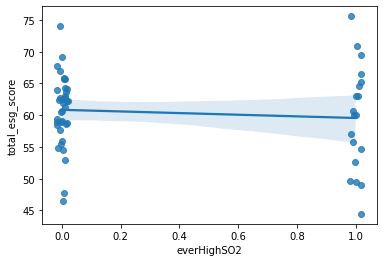

In [107]:
sns.regplot(data=sa_bs_pollution, x="everHighSO2", y="total_esg_score", x_jitter=0.02);

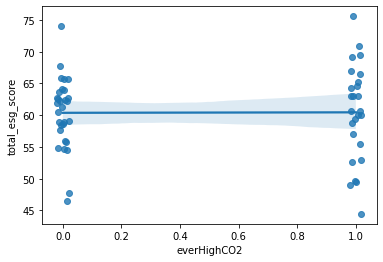

In [108]:
sns.regplot(data=sa_bs_pollution, x="everHighCO2", y="total_esg_score", x_jitter=0.02);

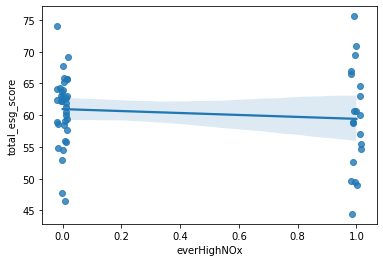

In [109]:
sns.regplot(data=sa_bs_pollution, x="everHighNOx", y="total_esg_score", x_jitter=0.02);

### Environment Scores vs Pollution Experience

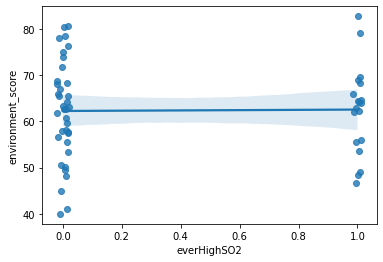

In [110]:
sns.regplot(data=sa_bs_pollution, x="everHighSO2", y="environment_score", x_jitter=0.02);

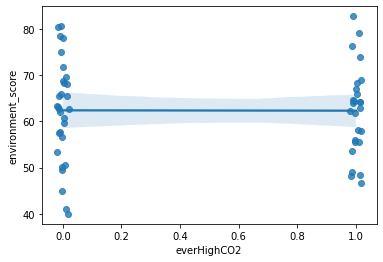

In [111]:
sns.regplot(data=sa_bs_pollution, x="everHighCO2", y="environment_score", x_jitter=0.02);

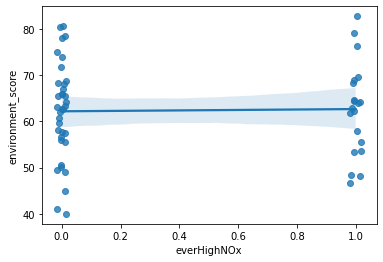

In [112]:
sns.regplot(data=sa_bs_pollution, x="everHighNOx", y="environment_score", x_jitter=0.02);

None of the above show any significant differences between politicians who experienced pollution and those did not. 

Potential improvements: 
- Account for buy/sell when computing weighted average
- Only include extreme ESG scores (because it's hard for typical people to see that a company with 70 ESG score is a more environmental responsible firm than a 69 ESG score one)

## Remedies

### 1. Categorizing using SICCD (industry code)

In [113]:
sa_bs_full = pd.read_csv("../data/minas_esg/sustainalytics_bs_merge.csv", encoding="latin-1")
with open("siccd.json") as f:
    polluting_siccd = json.load(f)["codes"]

In [114]:
sa_bs_full["polluting_by_siccd"] = sa_bs_full["siccd"].apply(lambda x: x in polluting_siccd)
sum(sa_bs_full["polluting_by_siccd"]) / len(sa_bs_full["polluting_by_siccd"])

0.10474188015271399

In [115]:
weighted_siccd = pd.DataFrame(sa_bs_full.groupby("icpsr_id")[["amountE", "polluting_by_siccd"]].apply(lambda x: sum(x["amountE"] * x["polluting_by_siccd"]) / sum(x["amountE"])))
weighted_siccd = weighted_siccd.merge(pollution, left_index=True, right_on="icpsr").rename(columns={0:"weightedPollutingInvestments"}).dropna().reset_index(drop=True)
weighted_siccd

,weightedPollutingInvestments,icpsr,congress,everHighSO2,everHighCO2,everHighNOx
0,0.353239,15015,224.0,0.0,0.0,0.0
1,0.059385,20305,224.0,0.0,0.0,0.0
2,0.000000,20325,224.0,0.0,0.0,0.0
3,0.777525,20342,224.0,0.0,0.0,0.0
4,0.952381,20356,224.0,0.0,0.0,0.0
5,0.000000,20519,224.0,0.0,0.0,0.0
6,0.137316,20532,224.0,0.0,1.0,1.0
7,0.500000,20542,225.0,1.0,1.0,1.0
8,0.000000,20704,225.0,0.0,0.0,0.0
9,0.067755,20708,225.0,1.0,1.0,1.0


In [116]:
weighted_siccd_w_controls = weighted_siccd.merge(d_controls, left_on="icpsr", right_on="icpsr")
weighted_siccd_w_controls["gender"] = weighted_siccd_w_controls["gender"].replace(to_replace={'M': 0, 'F': 1})
weighted_siccd_w_controls["party"] = weighted_siccd_w_controls["party"].replace(to_replace={'D': 0, 'R': 1})
weighted_siccd_w_controls

,weightedPollutingInvestments,icpsr,congress,everHighSO2,everHighCO2,everHighNOx,gender,party,seniority,chamber,born_year2
0,0.353239,15015,224.0,0.0,0.0,0.0,0,0,11.0,0.0,1947.0
1,0.059385,20305,224.0,0.0,0.0,0.0,0,0,10.0,2.0,1948.0
2,0.000000,20325,224.0,0.0,0.0,0.0,0,1,10.0,2.0,1949.0
3,0.777525,20342,224.0,0.0,0.0,0.0,0,1,10.0,2.0,1960.0
4,0.952381,20356,224.0,0.0,0.0,0.0,0,1,10.0,2.0,1941.0
5,0.000000,20519,224.0,0.0,0.0,0.0,0,0,6.0,2.0,1959.0
6,0.137316,20532,224.0,0.0,1.0,1.0,0,1,8.0,2.0,1951.0
7,0.500000,20542,225.0,1.0,1.0,1.0,0,0,8.0,2.0,1951.0
8,0.000000,20704,225.0,0.0,0.0,0.0,0,1,6.0,2.0,1954.0
9,0.067755,20708,225.0,1.0,1.0,1.0,1,0,6.0,2.0,1966.0


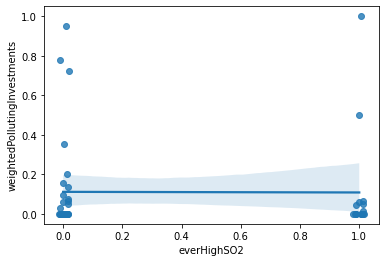

In [117]:
sns.regplot(data=weighted_siccd, x="everHighSO2", y="weightedPollutingInvestments", x_jitter=0.02);

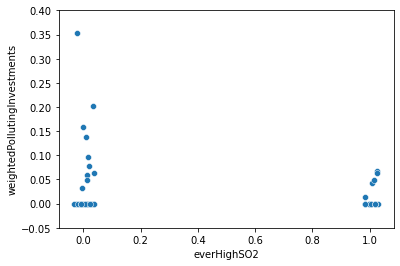

In [118]:
sns.scatterplot(data=weighted_siccd, x=jitter(weighted_siccd.everHighSO2, 0.02), y="weightedPollutingInvestments")
plt.ylim(-0.05, 0.4);

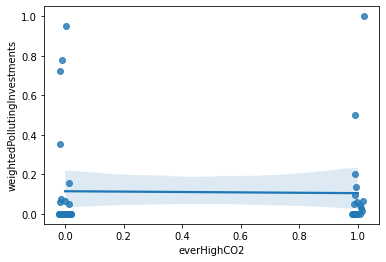

In [119]:
sns.regplot(data=weighted_siccd, x="everHighCO2", y="weightedPollutingInvestments", x_jitter=0.02);

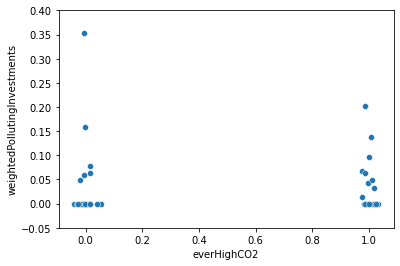

In [120]:
sns.scatterplot(data=weighted_siccd, x=jitter(weighted_siccd.everHighCO2, 0.02), y="weightedPollutingInvestments")
plt.ylim(-0.05, 0.4);

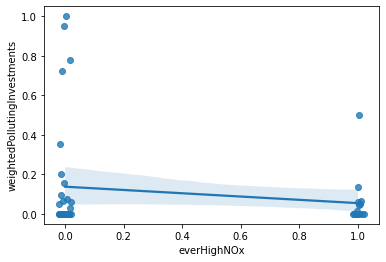

In [121]:
sns.regplot(data=weighted_siccd, x="everHighNOx", y="weightedPollutingInvestments", x_jitter=0.02);

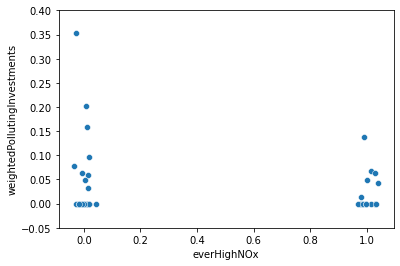

In [122]:
sns.scatterplot(data=weighted_siccd, x=jitter(weighted_siccd.everHighNOx, 0.02), y="weightedPollutingInvestments")
plt.ylim(-0.05, 0.4);

In [123]:
%%stata -d weighted_siccd -force
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2
eststo: quietly reg weightedPollutingInvestments everHighCO2
eststo: quietly reg weightedPollutingInvestments everHighNOx
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx
esttab, se r2 ar2
esttab, se r2 ar2, using ../output/siccd_all.tex, label replace booktabs


. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx
(est4 stored)

. esttab, se r2 ar2

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             weightedPo~s    weightedPo~s    weightedPo~s    weightedPo~s   
----------------------------------------------------------------------------
everHighSO2      -0.00311                                           0.104   
                 (0.0761)                                         (0.116)   

everHighCO2                      -0.00977                          0.0370   
                                 (0.0721)                        (0.0975)   

everHigh

In [131]:
%%stata -d weighted_siccd_w_controls -force
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.party i.chamber 
eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.party i.chamber
eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.party i.chamber
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx i.gender i.party i.chamber
esttab, se r2 ar2
esttab, se r2 ar2, using ../output/siccd_all_w_controls.tex, label replace booktabs


. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.party
>  i.chamber 
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.party
>  i.chamber
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.party
>  i.chamber
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx i.gender i.party i.chamber
(est4 stored)

. esttab, se r2 ar2

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             weightedPo~s    weightedPo~s    weightedPo~s    weightedPo~s   
----------------------------------------------------------------------------
everHighSO2        0.0111                                           0.165   
                 (0.0838)                                         (0.118)   

0.gender                0               0    

In [127]:
%%stata -d weighted_siccd_w_controls -force
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.congress i.party i.seniority i.chamber 
eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.congress i.party i.seniority i.chamber
eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.congress i.party i.seniority i.chamber
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx i.gender i.congress i.party i.seniority

esttab, se r2 ar2, using ../output/siccd_all_w_controls.tex, label replace booktabs


. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.congr
> ess i.party i.seniority i.chamber 
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.congr
> ess i.party i.seniority i.chamber
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.congr
> ess i.party i.seniority i.chamber
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx i.gender i.congress i.party i.seniority
(est4 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.congr
> ess i.party i.chamber 
(est5 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.congr
> ess i.party i.chamber
(est6 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.congr
> ess i.party i.chamber
(est7 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx

(output written to ../output/siccd_all_w_controls.tex)

. 


In [125]:
%%stata -d weighted_siccd -force
drop if weightedPollutingInvestments > 0.4
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2
eststo: quietly reg weightedPollutingInvestments everHighCO2
eststo: quietly reg weightedPollutingInvestments everHighNOx
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx
esttab, se r2 ar2
esttab, se r2 ar2, using ../output/siccd_wo_outliers.tex, label replace booktabs


. drop if weightedPollutingInvestments > 0.4
(5 observations deleted)

. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx
(est4 stored)

. esttab, se r2 ar2

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             weightedPo~s    weightedPo~s    weightedPo~s    weightedPo~s   
----------------------------------------------------------------------------
everHighSO2       -0.0241                                         -0.0411   
                 (0.0220)                                        (0.0341)   

everHighCO2                       0.00673                          0.0315   
               

In [52]:
%%stata -d weighted_siccd_w_controls -force
drop if weightedPollutingInvestments > 0.4
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.congress i.party i.seniority
eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.congress i.party i.seniority
eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.congress i.party i.seniority
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx i.gender i.congress i.party i.seniority
esttab, se r2 ar2
esttab, se r2 ar2, using ../output/siccd_wo_outliers_w_controls.tex, label replace booktabs


. drop if weightedPollutingInvestments > 0.4
(5 observations deleted)

. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.congr
> ess i.party i.seniority
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.congr
> ess i.party i.seniority
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.congr
> ess i.party i.seniority
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx i.gender i.congress i.party i.seniority
(est4 stored)

. esttab, se r2 ar2

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             weightedPo~s    weightedPo~s    weightedPo~s    weightedPo~s   
----------------------------------------------------------------------------
everHighSO2       -0.0140                                         -0.0349   
 

In [132]:
%%stata -d weighted_siccd_w_controls -force
drop if weightedPollutingInvestments > 0.4
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.party i.chamber 
eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.party i.chamber
eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.party i.chamber
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx i.gender i.party i.chamber
esttab, se r2 ar2
esttab, se r2 ar2, using ../output/siccd_wo_outliers_w_controls.tex, label replace booktabs


. drop if weightedPollutingInvestments > 0.4
(5 observations deleted)

. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2 i.gender i.party
>  i.chamber 
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2 i.gender i.party
>  i.chamber
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx i.gender i.party
>  i.chamber
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx i.gender i.party i.chamber
(est4 stored)

. esttab, se r2 ar2

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             weightedPo~s    weightedPo~s    weightedPo~s    weightedPo~s   
----------------------------------------------------------------------------
everHighSO2       -0.0218                                         -0.0574   
                 (0.0249)                           

### 2. "Cherry-Picked" Companies
People learn about environmental unfriendly from the news. The following is from [The Guardian](https://www.theguardian.com/environment/2019/oct/09/revealed-20-firms-third-carbon-emissions).
<img src="assets/theguardiantopco2producers.png" width="500"/>

In [28]:
tg_list = ['CVX', 'XOM', 'BP', 'SHEL', 'BTU', 'COP', 'TTE', 'BHP']

In [29]:
sa_bs_full["polluting_by_tg"] = sa_bs_full["ticker"].apply(lambda x: x in tg_list)
sum(sa_bs_full["polluting_by_tg"]) / len(sa_bs_full["polluting_by_tg"])

0.026392961876832845

In [30]:
weighted_tg = pd.DataFrame(sa_bs_full.groupby("icpsr_id")[["amountE", "polluting_by_tg"]].apply(lambda x: sum(x["amountE"] * x["polluting_by_tg"]) / sum(x["amountE"])))
weighted_tg = weighted_tg.merge(pollution, left_index=True, right_on="icpsr").rename(columns={0:"weightedPollutingInvestments"}).dropna().reset_index(drop=True)
weighted_tg

,weightedPollutingInvestments,icpsr,everHighSO2,everHighCO2,everHighNOx
0,0.025050,15015,0.0,0.0,0.0
1,0.000000,20305,0.0,0.0,0.0
2,0.000000,20325,0.0,0.0,0.0
3,0.058354,20342,0.0,0.0,0.0
4,0.952381,20356,0.0,0.0,0.0
5,0.000000,20519,0.0,0.0,0.0
6,0.020301,20532,0.0,1.0,1.0
7,0.500000,20542,1.0,1.0,1.0
8,0.000000,20704,0.0,0.0,0.0
9,0.000000,20708,1.0,1.0,1.0


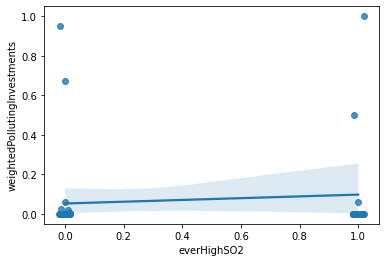

In [31]:
sns.regplot(data=weighted_tg, x="everHighSO2", y="weightedPollutingInvestments", x_jitter=0.02);

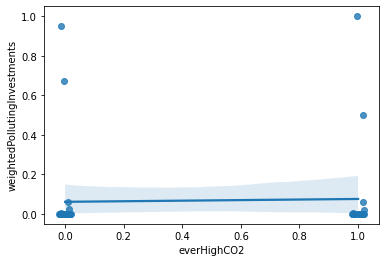

In [32]:
sns.regplot(data=weighted_tg, x="everHighCO2", y="weightedPollutingInvestments", x_jitter=0.02);

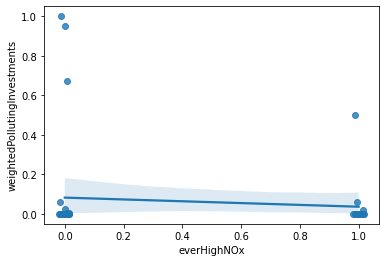

In [33]:
sns.regplot(data=weighted_tg, x="everHighNOx", y="weightedPollutingInvestments", x_jitter=0.02);

In [34]:
%%stata -d weighted_tg -force
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2
eststo: quietly reg weightedPollutingInvestments everHighCO2
eststo: quietly reg weightedPollutingInvestments everHighNOx
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx
esttab, se r2 ar2
esttab, se r2 ar2, using ../output/tg_all.tex, label replace booktabs


. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx
(est4 stored)

. esttab, se r2 ar2

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             weightedPo~s    weightedPo~s    weightedPo~s    weightedPo~s   
----------------------------------------------------------------------------
everHighSO2        0.0449                                           0.152   
                 (0.0685)                                         (0.104)   

everHighCO2                        0.0144                          0.0273   
                                 (0.0652)                        (0.0874)   

everHigh

In [35]:
%%stata -d weighted_tg -force
drop if weightedPollutingInvestments > 0.4
est clear
eststo: quietly reg weightedPollutingInvestments everHighSO2
eststo: quietly reg weightedPollutingInvestments everHighCO2
eststo: quietly reg weightedPollutingInvestments everHighNOx
eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 everHighNOx
esttab, se r2 ar2
esttab, se r2 ar2, using ../output/tg_wo_outliers.tex, label replace booktabs


. drop if weightedPollutingInvestments > 0.4
(4 observations deleted)

. est clear

. eststo: quietly reg weightedPollutingInvestments everHighSO2
(est1 stored)

. eststo: quietly reg weightedPollutingInvestments everHighCO2
(est2 stored)

. eststo: quietly reg weightedPollutingInvestments everHighNOx
(est3 stored)

. eststo: quietly reg weightedPollutingInvestments everHighSO2 everHighCO2 ever
> HighNOx
(est4 stored)

. esttab, se r2 ar2

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             weightedPo~s    weightedPo~s    weightedPo~s    weightedPo~s   
----------------------------------------------------------------------------
everHighSO2      0.000775                                        -0.00239   
                (0.00431)                                       (0.00678)   

everHighCO2                       0.00128                        0.000163   
               